In [21]:
from functools import partial

import jax
import matplotlib.pyplot as plt
from jax import random
from jaxtyping import Float, Array, PyTree, PRNGKeyArray

from ml.cost import mean_squared_error
from ml.definition import FloatScalar
from ml.nn import Dense, partition, combine
from ml.normalizer import get_z_score_normalizer
from ml.tools import generate_data

In [22]:
LEARNING_RATE = 0.01
CLIP_VALUE = 1.0
EPOCHES = 80000
PRINT_EVERY = 1000

In [23]:
key = random.PRNGKey(1234)
key, x, y = generate_data(
    key,
    (60,),
    -100.0,
    100.0,
    lambda x: 3 * x + 4 * x ** 2 + 110,
    20,
    20,
)
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [24]:
@jax.tree_util.register_pytree_node_class
class Model:
    def __init__(self, key: PRNGKeyArray):
        key1, key2 = random.split(key, 2)
        self.layers = [
            Dense(1, 10, key=key1, activation=jax.nn.relu),
            Dense(10, 1, key=key2),
        ]

    def __call__(self, x: Float[Array, "feature_size"]) -> Float[Array, "unit"]:
        for layer in self.layers:
            x = layer(x)
        return x

    def __repr__(self):
        return f"Model({self.layers})"

    def tree_flatten(self):
        return self.layers, None

    @classmethod
    def tree_unflatten(cls, _aux_data, children):
        del _aux_data
        model = cls.__new__(cls)
        model.layers = children
        return model

In [25]:
key, subkey = random.split(key)
model = Model(subkey)
params, static = partition(model)
print(model)

Model([Dense(units=10, w.shape=(10, 1), b.shape=(10,), activation=<jax._src.custom_derivatives.custom_jvp object at 0x7fb5b0b584d0>), Dense(units=1, w.shape=(1, 10), b.shape=(1,), activation=<function linear at 0x7fb585b772e0>)])


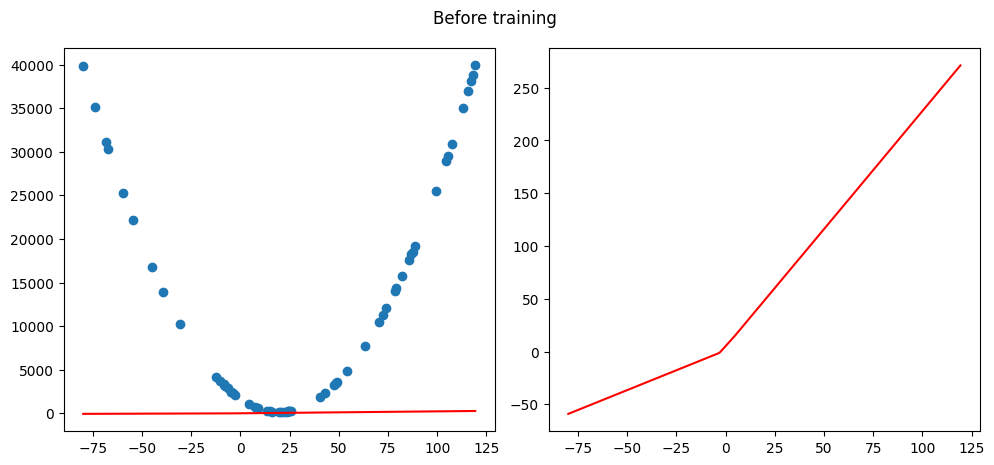

Before training: 321912544.0


In [26]:
@partial(jax.jit, static_argnames=("static",))
def loss(
        params: PyTree,
        static: PyTree,
        x: Float[Array, "batch feature"],
        y: Float[Array, "batch 1"],
) -> FloatScalar:
    combined_model = combine(params, static)
    prediction = jax.vmap(combined_model)(x)
    # return jax.numpy.abs(y - prediction).mean()
    return mean_squared_error(y, prediction)


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4.7))
fig.suptitle("Before training")
ax0.scatter(x, y)
ax0.plot(x, (jax.vmap(model)(x)), c="red")
ax1.plot(x, (jax.vmap(model)(x)), c="red")
plt.tight_layout()
plt.show()
print(f"Before training: {loss(params, static, x, y)}")

In [27]:
@partial(jax.jit, static_argnames=("static",))
def train_step(param, static, x, y, opt_state):
    value, grad = jax.value_and_grad(loss)(param, static, x, y)
    grad = jax.tree.map(lambda x: jax.numpy.clip(x, -CLIP_VALUE, CLIP_VALUE), grad)
    # update, opt_states = optimizer.update(grad, opt_state)
    # param = optax.apply_updates(param, update)
    param = jax.tree.map(lambda w, g: w - LEARNING_RATE * g, param, grad)
    return (
        param,
        value,
        opt_state,
    )


def training_loop(param, static, x, y):
    history = []
    # opt_state = optimizer.init(param)
    for i in range(EPOCHES):
        param, v, opt_state = train_step(
            param, static, x, y, None
        )  # None for the time being, todo: Implement optimizer
        if i % PRINT_EVERY == 0:
            history.append(v)
            print(f"Epoch: {i} Loss: {v}")
    return param, static, history

In [28]:
params, static, history = training_loop(params, static, x, y)
model = combine(params, static)
print(f"After training: {loss(params, static, x, y)}")

Epoch: 0 Loss: 321912544.0
Epoch: 1000 Loss: 26868216.0
Epoch: 2000 Loss: 25707670.0
Epoch: 3000 Loss: 22168986.0
Epoch: 4000 Loss: 17042816.0
Epoch: 5000 Loss: 11919675.0
Epoch: 6000 Loss: 7638953.0
Epoch: 7000 Loss: 4406586.5
Epoch: 8000 Loss: 2750755.5
Epoch: 9000 Loss: 1841091.875
Epoch: 10000 Loss: 1716124.125
Epoch: 11000 Loss: 1711689.125
Epoch: 12000 Loss: 1707321.125
Epoch: 13000 Loss: 1702820.5
Epoch: 14000 Loss: 1698873.375
Epoch: 15000 Loss: 1694923.125
Epoch: 16000 Loss: 1690835.875
Epoch: 17000 Loss: 1687025.875
Epoch: 18000 Loss: 1682999.875
Epoch: 19000 Loss: 1679126.875
Epoch: 20000 Loss: 1675733.0
Epoch: 21000 Loss: 1671740.125
Epoch: 22000 Loss: 1668170.0
Epoch: 23000 Loss: 1664576.625
Epoch: 24000 Loss: 1661259.5
Epoch: 25000 Loss: 1658212.625
Epoch: 26000 Loss: 1654629.375
Epoch: 27000 Loss: 1651723.625
Epoch: 28000 Loss: 1648484.0
Epoch: 29000 Loss: 1645093.25
Epoch: 30000 Loss: 1642196.375
Epoch: 31000 Loss: 1639759.25
Epoch: 32000 Loss: 1639639.875
Epoch: 33000 

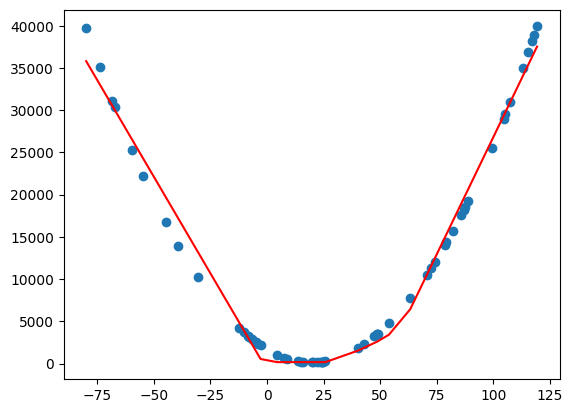

In [29]:
plt.scatter(x, y)
plt.plot(x, (jax.vmap(model)(x)), c="red")
plt.show()

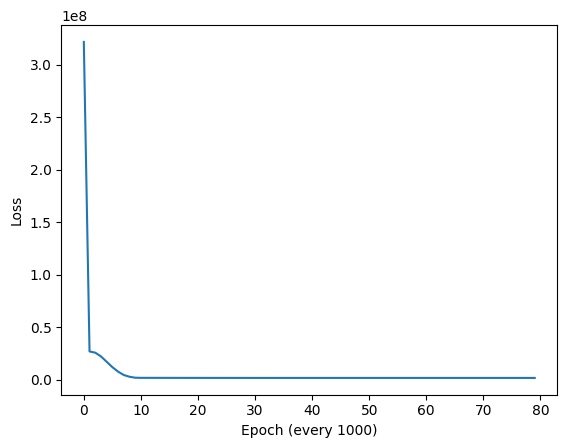

In [30]:
plt.plot(history)
plt.xlabel(f"Epoch (every {PRINT_EVERY})")
plt.ylabel("Loss")
plt.show()